In [1]:
__author__ = 'Daisuke Yoda'
__Date__ = 'December 2018'

## Loading Modules

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
__dir__ = os.getcwd()[:-11]

from chainer import Chain, Variable, optimizers
import chainer.functions as F
import chainer.links as L

from gensim.models.keyedvectors import KeyedVectors

## Define The three networks

In [129]:
class First_Network(Chain):
    def __init__(self, in_size, hidden_size, out_size):
        super(First_Network, self).__init__(
            hh = L.Linear(in_size, hidden_size),
            hy = L.Linear(hidden_size, out_size),
        )

    def __call__(self, x):
        x = Variable(x)
        h = self.hh(x)
        h = F.dropout(h,0.3)
        h = F.relu(h)
        y = self.hy(h)
        y = F.softmax(y)

        return y


class Second_Network(Chain):
    def __init__(self,vocab_size, in_size, out_size):
        super(Second_Network, self).__init__(
            xh=L.EmbedID(vocab_size, in_size),
            hh=L.LSTM(in_size, out_size),
        )

    def forward(self, x):
        #x = Variable(x)
        x = self.xh(x)
        if self.i == 0:
            self.x = x
        y = self.hh(x)

        return y

    def __call__(self,word):
        self.reset()
        
        self.i = 0
        """
        if word == []:
            return self.forward(np.array([0],dtype=np.int32))
        """
        for char in word:
            out = self.forward(char)
            self.i += 1

        return out

    def reset(self):
        self.hh.reset_state()


class Third_Network(Chain):
    def __init__(self, in_size, hidden_size, out_size):
        super(Third_Network, self).__init__(
            hh1 = L.Linear(in_size, hidden_size),
            hh2 =L.Linear(in_size, hidden_size),
            hy = L.Linear(hidden_size*2, out_size),
        )

    def __call__(self, x1,x2,t):
        t = Variable(t)
        h1 = self.hh1(x1)
        h2 = self.hh2(x2)
        h1 = F.dropout(h1,0.3)
        h2 = F.dropout(h2, 0.3)
        h1 = F.relu(h1)
        h2 = F.relu(h2)
        h = F.concat([h1, h2])
        out = self.hy(h)
        out = F.tanh(out)
        out = F.normalize(out)

        return F.mean_squared_error(out,t)

## Dataset

In [182]:
def word_to_index(word):
    word_index = [ord (char) - 97 for char in word]
    return word_index

word_vectors = KeyedVectors.load_word2vec_format(__dir__ + 'data/glove.6B.100d.bin')
df = pd.read_csv(__dir__ + 'data/split_point_2.csv',index_col=0)
df = df[np.random.permutation(df.columns.values)]
training_data = [np.array(word_to_index(x)) for x in df.columns]
word_vec = np.array([word_vectors.get_vector(word) for word in df.columns], dtype=np.float32)

## Defining the three network

In [188]:
first_net = First_Network(100,30,17)
second_net = Second_Network(27,30, 50)
second_net2 = Second_Network(27, 30, 50)
third_net = Third_Network(50, 50, 100)

optimizer1 = optimizers.Adam()
optimizer1.setup(first_net)

optimizer2 = optimizers.Adam()
optimizer2.setup(second_net)

optimizer3 = optimizers.Adam()
optimizer3.setup(second_net2)

optimizer4 = optimizers.Adam()
optimizer4.setup(third_net)

## Training

In [189]:
loss_record = []
f1_record = []
for i in range(80):
    first_net.cleargrads()
    second_net.cleargrads()
    second_net2.cleargrads()
    third_net.cleargrads()
    second_net.reset()
    second_net2.reset()

    f1 = first_net(word_vec)
    split_ix = np.argmax(f1.data,axis=1) 

    word1 = np.array([word[:np.int(ix)] for word,ix in zip(training_data,split_ix)])
    word2 = np.array([word[np.int(ix):] for word,ix in zip(training_data,split_ix)])

    word1 = F.pad_sequence(word1,padding=-1)
    word2 = F.pad_sequence(word2,padding=-1)

    y1 = second_net(word1.T)
    y2 = second_net2(word2.T)

    loss = third_net(y1,y2,word_vec)
    loss_record.append(float(loss.data))
    loss.backward(retain_grad=True)

    optimizer4.update()
    optimizer3.update()
    optimizer2.update()

    f1_loss = F.concat([second_net.x.grad,second_net2.x.grad])
    f1_loss = F.sum(F.absolute(f1_loss))
    f1_record.append(float(f1_loss.data))
    f1.grad = (f1 * f1_loss.data).data
    f1.backward(retain_grad=True)
    optimizer1.update()

## Loss Obserbation

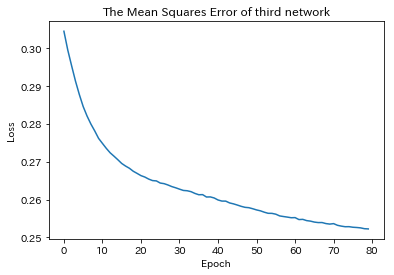

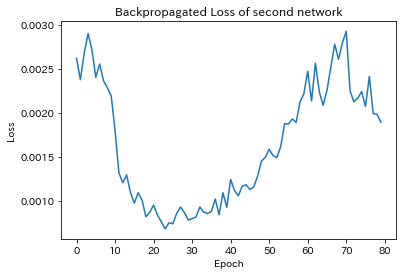

In [190]:
plt.plot(loss_record)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Mean Squares Error of third network')
plt.show()

plt.plot(f1_record)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Backpropagated Loss of second network')
plt.show()

## A example of splitting word

In [191]:
word1 = np.array([word[:np.int(ix)] for word,ix in zip(training_data,split_ix)])
word2 = np.array([word[np.int(ix):] for word,ix in zip(training_data,split_ix)])
print([chr(num+97) for num in word1[0]])
print([chr(num+97) for num in word2[0]])

['c', 'o', 'n', 'f', 'i']
['r', 'm', 'e', 'd']
